In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings

# Ignorar advertencias de convergencia de Lasso que pueden ocurrir con alphas pequeños
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning) # Ignorar futuras advertencias de scikit-learn/pandas

# --- 1. Cargar y Preparar los Datos ---
try:
    # Intenta cargar con la ruta proporcionada en la estructura de carpetas
    df = pd.read_csv('company.csv')
except FileNotFoundError:
    print("Archivo 'company.csv' no encontrado en la ruta especificada.")
    print("Asegúrate de que el archivo CSV esté en la carpeta.")
    # Detiene la ejecución si el archivo no se encuentra
    exit()

print("--- Información del Dataset ---")
df.info()
print("\n--- Primeras filas del Dataset ---")
print(df.head())
print("\n--- Estadísticas Descriptivas ---")
print(df.describe())

# Identificar columnas categóricas y numéricas
# Asumimos que la variable objetivo es 'Sales' (común en estos datasets)
target_column = 'Sales'
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

# Eliminar la columna objetivo de las características numéricas si está ahí
if target_column in numerical_features:
    numerical_features.remove(target_column)
# Eliminar la columna objetivo de las características categóricas si está ahí (poco probable)
if target_column in categorical_features:
    categorical_features.remove(target_column)

# Eliminar columnas que parecen identificadores (si las hubiera)
# En este caso 'Unnamed: 0' parece ser un índice residual de guardar el CSV
if 'Unnamed: 0' in numerical_features:
    numerical_features.remove('Unnamed: 0')
    df = df.drop(columns=['Unnamed: 0'])
elif 'Unnamed: 0' in df.columns: # Por si no fuera detectada como numérica
     df = df.drop(columns=['Unnamed: 0'])


print(f"\nCaracterísticas Categóricas: {categorical_features}")
print(f"Características Numéricas: {numerical_features}")
print(f"Variable Objetivo: {target_column}")

# Definir las características (X) y la variable objetivo (y)
X = df.drop(target_column, axis=1)
y = df[target_column]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el preprocesador
# - OneHotEncoder para las categóricas (maneja valores desconocidos y evita multicolinealidad)
# - StandardScaler para las numéricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)],
    remainder='passthrough') # Mantener otras columnas si las hubiera (aunque no debería haber) 


# --- 2. Búsqueda de Hiperparámetros (alpha) y Entrenamiento ---

# Definir un rango de valores para alpha
alphas = np.logspace(-4, 2, 100) # Rango amplio desde 0.0001 hasta 100

# Configurar KFold para la validación cruzada interna de *CV
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# RidgeCV: Busca el mejor alpha usando validación cruzada integrada
# El modelo se reentrena automáticamente con el mejor alpha encontrado en todo el set de entrenamiento
ridge_pipeline_cv = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('ridgecv', RidgeCV(alphas=alphas, cv=cv_strategy, scoring='neg_mean_squared_error'))])

ridge_pipeline_cv.fit(X_train, y_train)
best_alpha_ridge = ridge_pipeline_cv.named_steps['ridgecv'].alpha_
print(f"\nMejor alpha encontrado para Ridge: {best_alpha_ridge:.4f}")

# LassoCV: Busca el mejor alpha usando validación cruzada integrada
# Aumentamos max_iter por si acaso no converge con ciertos alphas
lasso_pipeline_cv = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('lassocv', LassoCV(alphas=alphas, cv=cv_strategy, max_iter=10000, random_state=42))])

lasso_pipeline_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_pipeline_cv.named_steps['lassocv'].alpha_
print(f"Mejor alpha encontrado para Lasso: {best_alpha_lasso:.4f}")

# --- 3. Comparación de Rendimiento con Validación Cruzada ---
# Usaremos los pipelines con los alphas óptimos encontrados para una evaluación más robusta

# Crear pipelines finales con los mejores alphas
ridge_pipeline_final = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('ridge', Ridge(alpha=best_alpha_ridge))])

lasso_pipeline_final = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('lasso', Lasso(alpha=best_alpha_lasso, max_iter=10000))]) # Usar max_iter alto

# Evaluar con validación cruzada en el conjunto de entrenamiento completo
# Usamos neg_mean_squared_error porque cross_val_score maximiza, y queremos minimizar el MSE
cv_scores_ridge = cross_val_score(ridge_pipeline_final, X_train, y_train, cv=cv_strategy, scoring='neg_mean_squared_error')
cv_scores_lasso = cross_val_score(lasso_pipeline_final, X_train, y_train, cv=cv_strategy, scoring='neg_mean_squared_error')

# Convertir a MSE positivo y calcular la media y desviación estándar
cv_mse_ridge_mean = -np.mean(cv_scores_ridge)
cv_mse_ridge_std = np.std(cv_scores_ridge)
cv_mse_lasso_mean = -np.mean(cv_scores_lasso)
cv_mse_lasso_std = np.std(cv_scores_lasso)

print(f"\n--- Validación Cruzada (MSE en Entrenamiento) ---")
print(f"Ridge CV MSE: {cv_mse_ridge_mean:.4f} (+/- {cv_mse_ridge_std:.4f})")
print(f"Lasso CV MSE: {cv_mse_lasso_mean:.4f} (+/- {cv_mse_lasso_std:.4f})")

# Evaluar R^2 con validación cruzada
cv_r2_ridge = cross_val_score(ridge_pipeline_final, X_train, y_train, cv=cv_strategy, scoring='r2')
cv_r2_lasso = cross_val_score(lasso_pipeline_final, X_train, y_train, cv=cv_strategy, scoring='r2')

print(f"\n--- Validación Cruzada (R^2 en Entrenamiento) ---")
print(f"Ridge CV R^2: {np.mean(cv_r2_ridge):.4f} (+/- {np.std(cv_r2_ridge):.4f})")
print(f"Lasso CV R^2: {np.mean(cv_r2_lasso):.4f} (+/- {np.std(cv_r2_lasso):.4f})")


# --- 4. Cálculo de Métricas en el Conjunto de Prueba ---

# Predicciones en el conjunto de prueba
y_pred_ridge = ridge_pipeline_cv.predict(X_test) # Usamos el modelo de RidgeCV que ya está entrenado
y_pred_lasso = lasso_pipeline_cv.predict(X_test) # Usamos el modelo de LassoCV que ya está entrenado

# Calcular métricas
mse_ridge_test = mean_squared_error(y_test, y_pred_ridge)
r2_ridge_test = r2_score(y_test, y_pred_ridge)
mse_lasso_test = mean_squared_error(y_test, y_pred_lasso)
r2_lasso_test = r2_score(y_test, y_pred_lasso)

print("\n--- Rendimiento en Conjunto de Prueba ---")
print(f"Ridge Test MSE: {mse_ridge_test:.4f}")
print(f"Ridge Test R^2: {r2_ridge_test:.4f}")
print(f"Lasso Test MSE: {mse_lasso_test:.4f}")
print(f"Lasso Test R^2: {r2_lasso_test:.4f}")

# --- 5. Análisis de Coeficientes ---

# Obtener los nombres de las características después del preprocesamiento
# ¡Importante! Hay que acceder al OneHotEncoder ajustado dentro del pipeline
feature_names = numerical_features + \
                list(ridge_pipeline_cv.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_features))

# Obtener los coeficientes de los modelos ajustados
coefs_ridge = ridge_pipeline_cv.named_steps['ridgecv'].coef_
coefs_lasso = lasso_pipeline_cv.named_steps['lassocv'].coef_

# Crear un DataFrame para comparar coeficientes
coef_comparison = pd.DataFrame({'Feature': feature_names,
                                'Ridge Coef (alpha={:.4f})'.format(best_alpha_ridge): coefs_ridge,
                                'Lasso Coef (alpha={:.4f})'.format(best_alpha_lasso): coefs_lasso})

print("\n--- Comparación de Coeficientes (con alpha óptimo) ---")
print(coef_comparison)

# Contar coeficientes cero en Lasso
zero_coef_lasso = np.sum(np.abs(coefs_lasso) < 1e-6) # Usar tolerancia pequeña
print(f"\nNúmero de coeficientes en Lasso cercanos a cero (magnitud < 1e-6): {zero_coef_lasso} de {len(coefs_lasso)}")

# --- 6 & 8 & 9. Discusión y Explicación ---

print("\n--- Discusión ---")

# Manejo de características no relevantes
print("\n* Manejo de características no relevantes:")
print("  - Ridge (Regularización L2): Reduce la magnitud de los coeficientes de todas las características, acercándolos a cero pero raramente haciéndolos exactamente cero. Es útil cuando muchas características tienen una pequeña/mediana contribución.")
print("  - Lasso (Regularización L1): Puede llevar los coeficientes de las características menos relevantes exactamente a cero. Realiza una selección automática de características, resultando en modelos más simples (dispersos). Es útil cuando se sospecha que muchas características son irrelevantes.")
print(f"  - En este dataset, Lasso con alpha={best_alpha_lasso:.4f} puso a cero (o casi cero) {zero_coef_lasso} coeficientes, sugiriendo que algunas características podrían ser menos importantes según este modelo.")

# Rendimiento en este dataset
print("\n* Rendimiento en este dataset:")
if mse_lasso_test < mse_ridge_test and r2_lasso_test > r2_ridge_test:
    print(f"  - Lasso (MSE={mse_lasso_test:.4f}, R^2={r2_lasso_test:.4f}) parece tener un rendimiento ligeramente mejor en el conjunto de prueba que Ridge (MSE={mse_ridge_test:.4f}, R^2={r2_ridge_test:.4f}).")
elif mse_ridge_test < mse_lasso_test and r2_ridge_test > r2_lasso_test:
     print(f"  - Ridge (MSE={mse_ridge_test:.4f}, R^2={r2_ridge_test:.4f}) parece tener un rendimiento ligeramente mejor en el conjunto de prueba que Lasso (MSE={mse_lasso_test:.4f}, R^2={r2_lasso_test:.4f}).")
else:
     print(f"  - Ambos modelos tienen un rendimiento muy similar en el conjunto de prueba (Ridge MSE={mse_ridge_test:.4f}, R^2={r2_ridge_test:.4f}; Lasso MSE={mse_lasso_test:.4f}, R^2={r2_lasso_test:.4f}). La elección podría depender de otros factores como la interpretabilidad (Lasso es más simple si elimina características).")
     # Comparación adicional con CV scores si los resultados de test son muy cercanos
     if cv_mse_lasso_mean < cv_mse_ridge_mean:
         print("  - La validación cruzada también sugiere una ligera ventaja para Lasso en términos de MSE promedio.")
     elif cv_mse_ridge_mean < cv_mse_lasso_mean:
         print("  - La validación cruzada también sugiere una ligera ventaja para Ridge en términos de MSE promedio.")


# Efecto de la regularización y ventajas
print("\n* Efecto de la regularización y ventajas:")
print("  - La regularización (tanto L1 como L2) añade un término de penalización a la función de coste de la regresión lineal.")
print("  - Penalización L2 (Ridge): Suma el cuadrado de la magnitud de los coeficientes (multiplicado por alpha). Disminuye la complejidad del modelo reduciendo los valores de los coeficientes.")
print("  - Penalización L1 (Lasso): Suma el valor absoluto de la magnitud de los coeficientes (multiplicado por alpha). Puede llevar coeficientes a cero, realizando selección de características.")
print("  - Ventajas Principales:")
print("    1. Reduce el sobreajuste (Overfitting): Al penalizar coeficientes grandes, se evita que el modelo se ajuste demasiado al ruido del conjunto de entrenamiento, mejorando la generalización a datos nuevos.")
print("    2. Maneja la Multicolinealidad: Ridge es particularmente efectivo cuando las características están altamente correlacionadas. Distribuye el 'impacto' entre las características correlacionadas en lugar de dar un peso muy grande a una sola.")
print("    3. Selección de Características (Lasso): Lasso simplifica el modelo eliminando características irrelevantes, lo que puede mejorar la interpretabilidad y a veces el rendimiento.")
print("    4. Mejora la Estabilidad: Los modelos regularizados tienden a ser más estables ante pequeñas variaciones en los datos de entrenamiento.")

# Cuándo usar Ridge vs Lasso
print("\n* ¿Cuándo usar Ridge sobre Lasso o viceversa?")
print("  - Usar Ridge si:")
print("    - Crees que la mayoría de las características son relevantes para el resultado.")
print("    - El principal problema es la multicolinealidad entre características.")
print("    - Prefieres un modelo que conserve todas las características, aunque con pesos reducidos.")
print("  - Usar Lasso si:")
print("    - Sospechas que muchas características son irrelevantes o redundantes.")
print("    - Buscas un modelo más simple y fácil de interpretar (con menos características).")
print("    - Quieres realizar selección automática de características.")
print("  - A menudo, también se considera Elastic Net, que combina ambas penalizaciones (L1 y L2) para obtener un equilibrio entre las ventajas de Ridge y Lasso.")

# --- 5. Análisis de Coeficientes ---

# Obtener los nombres de las características después del preprocesamiento
# Accedemos al preprocesador *ajustado* dentro del pipeline *ajustado*
fitted_preprocessor = ridge_pipeline_cv.named_steps['preprocessor']
# Accedemos al OneHotEncoder ('cat') *ajustado* dentro del preprocesador ajustado
fitted_ohe = fitted_preprocessor.named_transformers_['cat']
# Ahora obtenemos los nombres de las características generadas por el OHE ajustado
ohe_feature_names = list(fitted_ohe.get_feature_names_out(categorical_features))

# Combinamos con los nombres de las características numéricas originales
feature_names = numerical_features + ohe_feature_names

# Obtener los coeficientes de los modelos ajustados (esto debería funcionar como antes)
coefs_ridge = ridge_pipeline_cv.named_steps['ridgecv'].coef_
coefs_lasso = lasso_pipeline_cv.named_steps['lassocv'].coef_

# Crear un DataFrame para comparar coeficientes
# Asegúrate de que el número de coeficientes coincide con el número de feature_names
if len(feature_names) == len(coefs_ridge) and len(feature_names) == len(coefs_lasso):
    coef_comparison = pd.DataFrame({'Feature': feature_names,
                                    'Ridge Coef (alpha={:.4f})'.format(best_alpha_ridge): coefs_ridge,
                                    'Lasso Coef (alpha={:.4f})'.format(best_alpha_lasso): coefs_lasso})

    print("\n--- Comparación de Coeficientes (con alpha óptimo) ---")
    print(coef_comparison)

    # Contar coeficientes cero en Lasso
    zero_coef_lasso = np.sum(np.abs(coefs_lasso) < 1e-6) # Usar tolerancia pequeña
    print(f"\nNúmero de coeficientes en Lasso cercanos a cero (magnitud < 1e-6): {zero_coef_lasso} de {len(coefs_lasso)}")
else:
    print("\n¡Error! El número de nombres de características no coincide con el número de coeficientes.")
    print(f"Nombres de características encontrados: {len(feature_names)}")
    print(f"Coeficientes Ridge: {len(coefs_ridge)}")
    print(f"Coeficientes Lasso: {len(coefs_lasso)}")

# ... (El resto del código para Discusión y Gráficos sigue igual) ...

# --- [Código restante para Discusión y Gráficos] ---
# Copia aquí el resto del código desde la sección # --- 6 & 8 & 9. Discusión y Explicación ---
# hasta el final, incluyendo la generación de gráficos.

# --- 6 & 8 & 9. Discusión y Explicación ---

print("\n--- Discusión ---")

# Manejo de características no relevantes
print("\n* Manejo de características no relevantes:")
print("  - Ridge (Regularización L2): Reduce la magnitud de los coeficientes de todas las características, acercándolos a cero pero raramente haciéndolos exactamente cero. Es útil cuando muchas características tienen una pequeña/mediana contribución.")
print("  - Lasso (Regularización L1): Puede llevar los coeficientes de las características menos relevantes exactamente a cero. Realiza una selección automática de características, resultando en modelos más simples (dispersos). Es útil cuando se sospecha que muchas características son irrelevantes.")
# Asegurarse de que zero_coef_lasso se calculó correctamente arriba
if 'zero_coef_lasso' in locals():
    print(f"  - En este dataset, Lasso con alpha={best_alpha_lasso:.4f} puso a cero (o casi cero) {zero_coef_lasso} coeficientes, sugiriendo que algunas características podrían ser menos importantes según este modelo.")
else:
    print("  - (No se pudo calcular el número de coeficientes cero para Lasso debido a un error previo)")


# Rendimiento en este dataset
print("\n* Rendimiento en este dataset:")
if mse_lasso_test < mse_ridge_test and r2_lasso_test > r2_ridge_test:
    print(f"  - Lasso (MSE={mse_lasso_test:.4f}, R^2={r2_lasso_test:.4f}) parece tener un rendimiento ligeramente mejor en el conjunto de prueba que Ridge (MSE={mse_ridge_test:.4f}, R^2={r2_ridge_test:.4f}).")
elif mse_ridge_test < mse_lasso_test and r2_ridge_test > r2_lasso_test:
     print(f"  - Ridge (MSE={mse_ridge_test:.4f}, R^2={r2_ridge_test:.4f}) parece tener un rendimiento ligeramente mejor en el conjunto de prueba que Lasso (MSE={mse_lasso_test:.4f}, R^2={r2_lasso_test:.4f}).")
else:
     print(f"  - Ambos modelos tienen un rendimiento muy similar en el conjunto de prueba (Ridge MSE={mse_ridge_test:.4f}, R^2={r2_ridge_test:.4f}; Lasso MSE={mse_lasso_test:.4f}, R^2={r2_lasso_test:.4f}). La elección podría depender de otros factores como la interpretabilidad (Lasso es más simple si elimina características).")
     # Comparación adicional con CV scores si los resultados de test son muy cercanos
     if cv_mse_lasso_mean < cv_mse_ridge_mean:
         print("  - La validación cruzada también sugiere una ligera ventaja para Lasso en términos de MSE promedio.")
     elif cv_mse_ridge_mean < cv_mse_lasso_mean:
         print("  - La validación cruzada también sugiere una ligera ventaja para Ridge en términos de MSE promedio.")


# Efecto de la regularización y ventajas
print("\n* Efecto de la regularización y ventajas:")
print("  - La regularización (tanto L1 como L2) añade un término de penalización a la función de coste de la regresión lineal.")
print("  - Penalización L2 (Ridge): Suma el cuadrado de la magnitud de los coeficientes (multiplicado por alpha). Disminuye la complejidad del modelo reduciendo los valores de los coeficientes.")
print("  - Penalización L1 (Lasso): Suma el valor absoluto de la magnitud de los coeficientes (multiplicado por alpha). Puede llevar coeficientes a cero, realizando selección de características.")
print("  - Ventajas Principales:")
print("    1. Reduce el sobreajuste (Overfitting): Al penalizar coeficientes grandes, se evita que el modelo se ajuste demasiado al ruido del conjunto de entrenamiento, mejorando la generalización a datos nuevos.")
print("    2. Maneja la Multicolinealidad: Ridge es particularmente efectivo cuando las características están altamente correlacionadas. Distribuye el 'impacto' entre las características correlacionadas en lugar de dar un peso muy grande a una sola.")
print("    3. Selección de Características (Lasso): Lasso simplifica el modelo eliminando características irrelevantes, lo que puede mejorar la interpretabilidad y a veces el rendimiento.")
print("    4. Mejora la Estabilidad: Los modelos regularizados tienden a ser más estables ante pequeñas variaciones en los datos de entrenamiento.")

# Cuándo usar Ridge vs Lasso
print("\n* ¿Cuándo usar Ridge sobre Lasso o viceversa?")
print("  - Usar Ridge si:")
print("    - Crees que la mayoría de las características son relevantes para el resultado.")
print("    - El principal problema es la multicolinealidad entre características.")
print("    - Prefieres un modelo que conserve todas las características, aunque con pesos reducidos.")
print("  - Usar Lasso si:")
print("    - Sospechas que muchas características son irrelevantes o redundantes.")
print("    - Buscas un modelo más simple y fácil de interpretar (con menos características).")
print("    - Quieres realizar selección automática de características.")
print("  - A menudo, también se considera Elastic Net, que combina ambas penalizaciones (L1 y L2) para obtener un equilibrio entre las ventajas de Ridge y Lasso.")

# --- 10. Gráficos de Coeficientes en función de alpha ---

n_alphas = 100
alphas_plot = np.logspace(-5, 1, n_alphas) # Rango diferente para visualización
coefs_ridge_path = []
coefs_lasso_path = []

# Necesitamos re-entrenar modelos para cada alpha del rango de visualización
# Asegurémonos de que el preprocesador está ajustado antes del bucle
# Preprocesador ya ajustado previamente al hacer fit en el pipeline_cv
# Usamos el ajustado para transformar X_train una sola vez
X_train_processed = ridge_pipeline_cv.named_steps['preprocessor'].transform(X_train)


for a in alphas_plot:
    # Ridge
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_processed, y_train)
    coefs_ridge_path.append(ridge.coef_)

    # Lasso
    lasso = Lasso(alpha=a, max_iter=10000, tol=0.01) # Aumentar tol para convergencia más rápida en gráfico
    lasso.fit(X_train_processed, y_train)
    coefs_lasso_path.append(lasso.coef_)

# Convertir listas de coeficientes a arrays numpy
coefs_ridge_path = np.array(coefs_ridge_path)
coefs_lasso_path = np.array(coefs_lasso_path)

# Crear gráficos
plt.figure(figsize=(14, 6))

# Gráfico para Ridge
plt.subplot(1, 2, 1)
ax1 = plt.gca()
# Asegurar que coefs_ridge_path no está vacío y tiene la forma correcta
if coefs_ridge_path.shape[0] == len(alphas_plot):
    ax1.plot(alphas_plot, coefs_ridge_path)
    ax1.set_xscale('log')
    ax1.set_xlim(ax1.get_xlim()[::-1]) # Invertir eje x para ver efecto de alpha creciente
    plt.xlabel('Alpha (Parámetro de Regularización)')
    plt.ylabel('Valor del Coeficiente')
    plt.title('Coeficientes de Ridge vs. Alpha')
    plt.axvline(best_alpha_ridge, linestyle='--', color='k', alpha=0.5, label=f'Alpha Óptimo = {best_alpha_ridge:.4f}')
    plt.legend()
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'Error al generar datos para Ridge Path', horizontalalignment='center', verticalalignment='center')


# Gráfico para Lasso
plt.subplot(1, 2, 2)
ax2 = plt.gca()
# Asegurar que coefs_lasso_path no está vacío y tiene la forma correcta
if coefs_lasso_path.shape[0] == len(alphas_plot):
    ax2.plot(alphas_plot, coefs_lasso_path)
    ax2.set_xscale('log')
    ax2.set_xlim(ax2.get_xlim()[::-1]) # Invertir eje x
    plt.xlabel('Alpha (Parámetro de Regularización)')
    plt.ylabel('Valor del Coeficiente')
    plt.title('Coeficientes de Lasso vs. Alpha')
    plt.axvline(best_alpha_lasso, linestyle='--', color='k', alpha=0.5, label=f'Alpha Óptimo = {best_alpha_lasso:.4f}')
    plt.legend()
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'Error al generar datos para Lasso Path', horizontalalignment='center', verticalalignment='center')


plt.tight_layout()
plt.suptitle('Evolución de los Coeficientes con la Regularización', y=1.02) # Título general
plt.show()

print("\n--- Análisis de Gráficos de Coeficientes ---")
print("* Gráfico de Ridge:")
print("  - Se observa cómo todos los coeficientes tienden gradualmente hacia cero a medida que alpha aumenta (la penalización es mayor).")
print("  - Los coeficientes rara vez llegan a ser exactamente cero, incluso con alphas relativamente altos.")
print("* Gráfico de Lasso:")
print("  - Se ve claramente cómo muchos coeficientes son forzados a ser exactamente cero a medida que alpha aumenta.")
print("  - El proceso de selección de características es visible: las líneas de los coeficientes 'menos importantes' tocan el eje y=0 antes que las de los coeficientes más relevantes.")
print("  - Con alphas suficientemente grandes, todos los coeficientes pueden llegar a ser cero.")

--- Información del Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB

--- Primeras filas del Dataset ---
      TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3   12.0
3  151.5   41.3       58.5   16.5
4  180.8   10.8       58.4   17.9

--- Estadísticas Descriptivas ---
               TV       Radio   Newspaper       Sales
count  200.000000  200.000000  200.000000  200.000000
mean   147.042500   23.264000   30.554000   15.130500
std     85.854236   14.846809   21.778621    5.283892
min      0.700000    0.000000    0.300000    1.600000
25%     74.375000    9.975000   12.7500

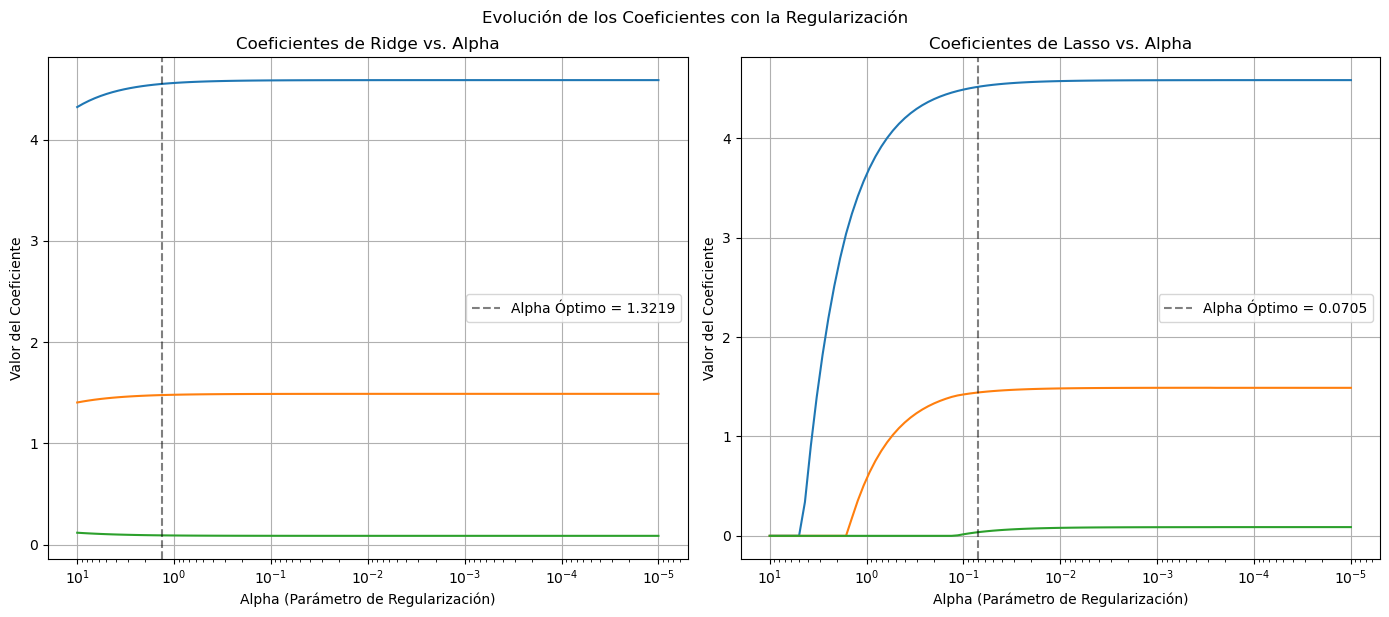


--- Análisis de Gráficos de Coeficientes ---
* Gráfico de Ridge:
  - Se observa cómo todos los coeficientes tienden gradualmente hacia cero a medida que alpha aumenta (la penalización es mayor).
  - Los coeficientes rara vez llegan a ser exactamente cero, incluso con alphas relativamente altos.
* Gráfico de Lasso:
  - Se ve claramente cómo muchos coeficientes son forzados a ser exactamente cero a medida que alpha aumenta.
  - El proceso de selección de características es visible: las líneas de los coeficientes 'menos importantes' tocan el eje y=0 antes que las de los coeficientes más relevantes.
  - Con alphas suficientemente grandes, todos los coeficientes pueden llegar a ser cero.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings

# Ignorar advertencias
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. Cargar y Preparar los Datos ---
try:
    df = pd.read_csv('company.csv')
except FileNotFoundError:
    print("Archivo 'company.csv' no encontrado.")
    exit()

# (Mismo código de info, head, describe que antes...)
print("--- Información del Dataset ---")
df.info()
print("\n--- Primeras filas del Dataset ---")
print(df.head())
print("\n--- Estadísticas Descriptivas ---")
print(df.describe())


target_column = 'Sales'
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()

if target_column in numerical_features:
    numerical_features.remove(target_column)
if target_column in categorical_features:
    categorical_features.remove(target_column)

if 'Unnamed: 0' in numerical_features:
    numerical_features.remove('Unnamed: 0')
    df = df.drop(columns=['Unnamed: 0'])
elif 'Unnamed: 0' in df.columns:
     df = df.drop(columns=['Unnamed: 0'])

print(f"\nCaracterísticas Categóricas: {categorical_features}")
print(f"Características Numéricas: {numerical_features}")
print(f"Variable Objetivo: {target_column}")

X = df.drop(target_column, axis=1)
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Preprocesador ---
# Definir el preprocesador (igual que antes)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

# --- NUEVO PASO: Ajustar el preprocesador por separado para obtener los nombres ---
print("\nAjustando preprocesador por separado para obtener nombres de características...")
# Ajustamos el preprocesador SOLO con los datos de entrenamiento
preprocessor.fit(X_train)

# Intentamos obtener los nombres AHORA, desde el preprocesador ajustado explícitamente
try:
    fitted_ohe = preprocessor.named_transformers_['cat']
    ohe_feature_names = list(fitted_ohe.get_feature_names_out(categorical_features))
    # Lista final de nombres de características
    feature_names = numerical_features + ohe_feature_names
    print(f"Nombres de características obtenidos ({len(feature_names)}): {feature_names}")
except Exception as e:
    print(f"\nError al obtener nombres de características del preprocesador ajustado por separado: {e}")
    print("No se podrán mostrar los coeficientes con nombres correctos.")
    # Crear nombres genéricos si falla la obtención
    # Primero transformamos para saber cuántas columnas hay
    try:
        X_train_processed_check = preprocessor.transform(X_train)
        n_features_out = X_train_processed_check.shape[1]
        feature_names = [f'feature_{i}' for i in range(n_features_out)]
        print(f"Usando nombres genéricos: {feature_names}")
    except:
        print("Fallo al transformar datos para obtener número de columnas. Abortando análisis de coeficientes.")
        feature_names = [] # Dejar vacío para que falle la comparación posterior


# --- 2. Búsqueda de Hiperparámetros (alpha) y Entrenamiento ---
# Los pipelines usarán la DEFINICIÓN del preprocesador (se ajustará internamente de nuevo)

alphas = np.logspace(-4, 2, 100)
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# Definir pipelines (¡usan la definición del preprocesador, no el ajustado!)
ridge_pipeline_cv = Pipeline(steps=[('preprocessor', preprocessor), # Pasa la definición
                                    ('ridgecv', RidgeCV(alphas=alphas, cv=cv_strategy, scoring='neg_mean_squared_error'))])

lasso_pipeline_cv = Pipeline(steps=[('preprocessor', preprocessor), # Pasa la definición
                                    ('lassocv', LassoCV(alphas=alphas, cv=cv_strategy, max_iter=10000, random_state=42))])

# Ajustar los pipelines completos (esto ajustará sus preprocesadores internos)
print("\nAjustando pipeline RidgeCV...")
ridge_pipeline_cv.fit(X_train, y_train)
best_alpha_ridge = ridge_pipeline_cv.named_steps['ridgecv'].alpha_
print(f"Mejor alpha encontrado para Ridge: {best_alpha_ridge:.4f}")

print("\nAjustando pipeline LassoCV...")
lasso_pipeline_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_pipeline_cv.named_steps['lassocv'].alpha_
print(f"Mejor alpha encontrado para Lasso: {best_alpha_lasso:.4f}")


# --- 3. Comparación de Rendimiento con Validación Cruzada ---
# (Esta sección no cambia, usa los pipelines ajustados)
print("\n--- Validación Cruzada (MSE en Entrenamiento) ---")
# Crear pipelines finales con los mejores alphas para CV explícita
ridge_pipeline_final = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('ridge', Ridge(alpha=best_alpha_ridge))])
lasso_pipeline_final = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('lasso', Lasso(alpha=best_alpha_lasso, max_iter=10000))])

cv_scores_ridge = cross_val_score(ridge_pipeline_final, X_train, y_train, cv=cv_strategy, scoring='neg_mean_squared_error')
cv_scores_lasso = cross_val_score(lasso_pipeline_final, X_train, y_train, cv=cv_strategy, scoring='neg_mean_squared_error')

cv_mse_ridge_mean = -np.mean(cv_scores_ridge)
cv_mse_ridge_std = np.std(cv_scores_ridge)
cv_mse_lasso_mean = -np.mean(cv_scores_lasso)
cv_mse_lasso_std = np.std(cv_scores_lasso)
print(f"Ridge CV MSE: {cv_mse_ridge_mean:.4f} (+/- {cv_mse_ridge_std:.4f})")
print(f"Lasso CV MSE: {cv_mse_lasso_mean:.4f} (+/- {cv_mse_lasso_std:.4f})")

print("\n--- Validación Cruzada (R^2 en Entrenamiento) ---")
cv_r2_ridge = cross_val_score(ridge_pipeline_final, X_train, y_train, cv=cv_strategy, scoring='r2')
cv_r2_lasso = cross_val_score(lasso_pipeline_final, X_train, y_train, cv=cv_strategy, scoring='r2')
print(f"Ridge CV R^2: {np.mean(cv_r2_ridge):.4f} (+/- {np.std(cv_r2_ridge):.4f})")
print(f"Lasso CV R^2: {np.mean(cv_r2_lasso):.4f} (+/- {np.std(cv_r2_lasso):.4f})")


# --- 4. Cálculo de Métricas en el Conjunto de Prueba ---
# (Esta sección no cambia)
print("\n--- Rendimiento en Conjunto de Prueba ---")
y_pred_ridge = ridge_pipeline_cv.predict(X_test)
y_pred_lasso = lasso_pipeline_cv.predict(X_test)

mse_ridge_test = mean_squared_error(y_test, y_pred_ridge)
r2_ridge_test = r2_score(y_test, y_pred_ridge)
mse_lasso_test = mean_squared_error(y_test, y_pred_lasso)
r2_lasso_test = r2_score(y_test, y_pred_lasso)

print(f"Ridge Test MSE: {mse_ridge_test:.4f}")
print(f"Ridge Test R^2: {r2_ridge_test:.4f}")
print(f"Lasso Test MSE: {mse_lasso_test:.4f}")
print(f"Lasso Test R^2: {r2_lasso_test:.4f}")


# --- 5. Análisis de Coeficientes ---
# Usamos la variable feature_names que obtuvimos ANTES de ajustar los pipelines CV
print("\n--- Comparación de Coeficientes (con alpha óptimo) ---")

coefs_ridge = ridge_pipeline_cv.named_steps['ridgecv'].coef_
coefs_lasso = lasso_pipeline_cv.named_steps['lassocv'].coef_

# Comprobar si tenemos nombres de características válidos
if feature_names and len(feature_names) == len(coefs_ridge) and len(feature_names) == len(coefs_lasso):
    coef_comparison = pd.DataFrame({'Feature': feature_names,
                                    'Ridge Coef (alpha={:.4f})'.format(best_alpha_ridge): coefs_ridge,
                                    'Lasso Coef (alpha={:.4f})'.format(best_alpha_lasso): coefs_lasso})
    print(coef_comparison)

    zero_coef_lasso = np.sum(np.abs(coefs_lasso) < 1e-6)
    print(f"\nNúmero de coeficientes en Lasso cercanos a cero (magnitud < 1e-6): {zero_coef_lasso} de {len(coefs_lasso)}")
else:
    print("\n¡Advertencia! No se pudieron obtener/validar los nombres de las características.")
    print("Mostrando coeficientes sin nombres:")
    print("\nCoeficientes Ridge:")
    print(coefs_ridge)
    print("\nCoeficientes Lasso:")
    print(coefs_lasso)
    if 'coefs_lasso' in locals():
      zero_coef_lasso = np.sum(np.abs(coefs_lasso) < 1e-6)
      print(f"\nNúmero de coeficientes en Lasso cercanos a cero (magnitud < 1e-6): {zero_coef_lasso} de {len(coefs_lasso)}")


# --- [Código restante para Discusión y Gráficos] ---
# Copia aquí el resto del código desde la sección # --- 6 & 8 & 9. Discusión y Explicación ---
# hasta el final, incluyendo la generación de gráficos.
# Asegúrate de que la sección de gráficos transforma los datos usando
# el preprocesador ajustado por separado o uno de los pipelines ajustados.

# --- 6 & 8 & 9. Discusión y Explicación ---
print("\n--- Discusión ---")
# (El texto de la discusión permanece igual, pero podría necesitar
#  ajustes si zero_coef_lasso no se pudo calcular)
# Manejo de características no relevantes
print("\n* Manejo de características no relevantes:")
print("  - Ridge (Regularización L2): Reduce la magnitud de los coeficientes de todas las características, acercándolos a cero pero raramente haciéndolos exactamente cero. Es útil cuando muchas características tienen una pequeña/mediana contribución.")
print("  - Lasso (Regularización L1): Puede llevar los coeficientes de las características menos relevantes exactamente a cero. Realiza una selección automática de características, resultando en modelos más simples (dispersos). Es útil cuando se sospecha que muchas características son irrelevantes.")
if 'zero_coef_lasso' in locals():
    print(f"  - En este dataset, Lasso con alpha={best_alpha_lasso:.4f} puso a cero (o casi cero) {zero_coef_lasso} coeficientes, sugiriendo que algunas características podrían ser menos importantes según este modelo.")
else:
    print("  - (No se pudo calcular el número de coeficientes cero para Lasso debido a un error previo en la obtención de nombres/coeficientes)")

# Rendimiento en este dataset
print("\n* Rendimiento en este dataset:")
if mse_lasso_test < mse_ridge_test and r2_lasso_test > r2_ridge_test:
    print(f"  - Lasso (MSE={mse_lasso_test:.4f}, R^2={r2_lasso_test:.4f}) parece tener un rendimiento ligeramente mejor en el conjunto de prueba que Ridge (MSE={mse_ridge_test:.4f}, R^2={r2_ridge_test:.4f}).")
elif mse_ridge_test < mse_lasso_test and r2_ridge_test > r2_lasso_test:
     print(f"  - Ridge (MSE={mse_ridge_test:.4f}, R^2={r2_ridge_test:.4f}) parece tener un rendimiento ligeramente mejor en el conjunto de prueba que Lasso (MSE={mse_lasso_test:.4f}, R^2={r2_lasso_test:.4f}).")
else:
     print(f"  - Ambos modelos tienen un rendimiento muy similar en el conjunto de prueba (Ridge MSE={mse_ridge_test:.4f}, R^2={r2_ridge_test:.4f}; Lasso MSE={mse_lasso_test:.4f}, R^2={r2_lasso_test:.4f}). La elección podría depender de otros factores como la interpretabilidad (Lasso es más simple si elimina características).")
     if cv_mse_lasso_mean < cv_mse_ridge_mean:
         print("  - La validación cruzada también sugiere una ligera ventaja para Lasso en términos de MSE promedio.")
     elif cv_mse_ridge_mean < cv_mse_lasso_mean:
         print("  - La validación cruzada también sugiere una ligera ventaja para Ridge en términos de MSE promedio.")


# Efecto de la regularización y ventajas
print("\n* Efecto de la regularización y ventajas:")
print("  - La regularización (tanto L1 como L2) añade un término de penalización a la función de coste de la regresión lineal.")
print("  - Penalización L2 (Ridge): Suma el cuadrado de la magnitud de los coeficientes (multiplicado por alpha). Disminuye la complejidad del modelo reduciendo los valores de los coeficientes.")
print("  - Penalización L1 (Lasso): Suma el valor absoluto de la magnitud de los coeficientes (multiplicado por alpha). Puede llevar coeficientes a cero, realizando selección de características.")
print("  - Ventajas Principales:")
print("    1. Reduce el sobreajuste (Overfitting): Al penalizar coeficientes grandes, se evita que el modelo se ajuste demasiado al ruido del conjunto de entrenamiento, mejorando la generalización a datos nuevos.")
print("    2. Maneja la Multicolinealidad: Ridge es particularmente efectivo cuando las características están altamente correlacionadas. Distribuye el 'impacto' entre las características correlacionadas en lugar de dar un peso muy grande a una sola.")
print("    3. Selección de Características (Lasso): Lasso simplifica el modelo eliminando características irrelevantes, lo que puede mejorar la interpretabilidad y a veces el rendimiento.")
print("    4. Mejora la Estabilidad: Los modelos regularizados tienden a ser más stables ante pequeñas variaciones en los datos de entrenamiento.")

# Cuándo usar Ridge vs Lasso
print("\n* ¿Cuándo usar Ridge sobre Lasso o viceversa?")
print("  - Usar Ridge si:")
print("    - Crees que la mayoría de las características son relevantes para el resultado.")
print("    - El principal problema es la multicolinealidad entre características.")
print("    - Prefieres un modelo que conserve todas las características, aunque con pesos reducidos.")
print("  - Usar Lasso si:")
print("    - Sospechas que muchas características son irrelevantes o redundantes.")
print("    - Buscas un modelo más simple y fácil de interpretar (con menos características).")
print("    - Quieres realizar selección automática de características.")
print("  - A menudo, también se considera Elastic Net, que combina ambas penalizaciones (L1 y L2) para obtener un equilibrio entre las ventajas de Ridge y Lasso.")


# --- 10. Gráficos de Coeficientes en función de alpha ---
print("\n--- Generando Gráficos de Coeficientes ---")
n_alphas = 100
alphas_plot = np.logspace(-5, 1, n_alphas)
coefs_ridge_path = []
coefs_lasso_path = []

# Usamos el preprocesador ajustado por separado para transformar X_train
# (Asegúrate de que preprocessor.fit(X_train) se ejecutó correctamente antes)
try:
    X_train_processed = preprocessor.transform(X_train) # Transformar datos para el bucle
    print("Datos de entrenamiento transformados para gráficos.")

    for a in alphas_plot:
        # Ridge
        ridge = Ridge(alpha=a)
        ridge.fit(X_train_processed, y_train)
        coefs_ridge_path.append(ridge.coef_)

        # Lasso
        lasso = Lasso(alpha=a, max_iter=10000, tol=0.01)
        lasso.fit(X_train_processed, y_train)
        coefs_lasso_path.append(lasso.coef_)

    coefs_ridge_path = np.array(coefs_ridge_path)
    coefs_lasso_path = np.array(coefs_lasso_path)

    # Crear gráficos (mismo código de plot que antes)
    plt.figure(figsize=(14, 6))

    # Gráfico para Ridge
    plt.subplot(1, 2, 1)
    ax1 = plt.gca()
    if coefs_ridge_path.shape[0] == len(alphas_plot):
        ax1.plot(alphas_plot, coefs_ridge_path)
        ax1.set_xscale('log')
        ax1.set_xlim(ax1.get_xlim()[::-1])
        plt.xlabel('Alpha (Parámetro de Regularización)')
        plt.ylabel('Valor del Coeficiente')
        plt.title('Coeficientes de Ridge vs. Alpha')
        plt.axvline(best_alpha_ridge, linestyle='--', color='k', alpha=0.5, label=f'Alpha Óptimo = {best_alpha_ridge:.4f}')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Error al generar datos para Ridge Path', horizontalalignment='center', verticalalignment='center')

    # Gráfico para Lasso
    plt.subplot(1, 2, 2)
    ax2 = plt.gca()
    if coefs_lasso_path.shape[0] == len(alphas_plot):
        ax2.plot(alphas_plot, coefs_lasso_path)
        ax2.set_xscale('log')
        ax2.set_xlim(ax2.get_xlim()[::-1])
        plt.xlabel('Alpha (Parámetro de Regularización)')
        plt.ylabel('Valor del Coeficiente')
        plt.title('Coeficientes de Lasso vs. Alpha')
        plt.axvline(best_alpha_lasso, linestyle='--', color='k', alpha=0.5, label=f'Alpha Óptimo = {best_alpha_lasso:.4f}')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Error al generar datos para Lasso Path', horizontalalignment='center', verticalalignment='center')


    plt.tight_layout()
    plt.suptitle('Evolución de los Coeficientes con la Regularización', y=1.02)
    plt.show()

    print("\n--- Análisis de Gráficos de Coeficientes ---")
    print("* Gráfico de Ridge:")
    print("  - Se observa cómo todos los coeficientes tienden gradualmente hacia cero a medida que alpha aumenta (la penalización es mayor).")
    print("  - Los coeficientes rara vez llegan a ser exactamente cero, incluso con alphas relativamente altos.")
    print("* Gráfico de Lasso:")
    print("  - Se ve claramente cómo muchos coeficientes son forzados a ser exactamente cero a medida que alpha aumenta.")
    print("  - El proceso de selección de características es visible: las líneas de los coeficientes 'menos importantes' tocan el eje y=0 antes que las de los coeficientes más relevantes.")
    print("  - Con alphas suficientemente grandes, todos los coeficientes pueden llegar a ser cero.")

except Exception as e:
    print(f"\nError durante la generación de gráficos: {e}")